In [22]:
import pandas as pd 
import numpy as np 
import sys
sys.path.insert(0, '../make_source_label_hierarchy/')
import os
os.environ['OPENAI_API_KEY']=open('/Users/spangher/.openai-isi-project-key.txt').read().strip()
from utils_client import call_openai_completions

In [880]:
source_df = pd.read_csv('../make_source_label_hierarchy/similarity_training_data/full-source-df-with-clusters.csv')
cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')

In [127]:
LEAF_NODE_PROMPT = """
You are a helpful assistant. I will give you a large set of labels I wrote down.

Here are the labels:

{labels}

Please summarize them with a single, specific label for the entire group. Be descriptive so I can really understand.
Please return just one label and one description. Make it in the same format as the input labels.
"""

In [109]:
labels = source_df.loc[lambda df: df['clusters'] == 9].sample(50)['Narrative Function']
call_openai_completions(prompt=LEAF_NODE_PROMPT.format(labels='\n'.join(labels)))

'"Public Health Authority": This collective label is assigned to sources that provide credible, expert information and guidance on public health topics, including but not limited to vaccine safety, effectiveness, clinical trials, pandemic response measures, and disease prevention. These sources are often official health organizations, government agencies, or reputable experts in the field of medicine and science, whose statements are widely recognized and trusted.'

In [124]:
from tqdm.auto import tqdm
groups = list(source_df.groupby('clusters')['Narrative Function'])
child_node_summaries = {}
for cluster_id, g in tqdm(groups):
    g = g.dropna()
    label_sample = g.sample(min(len(g), 50))
    summary_label = call_openai_completions(prompt=LEAF_NODE_PROMPT.format(labels='\n'.join(label_sample)))
    child_node_summaries[cluster_id] = summary_label

  0%|          | 0/1024 [00:00<?, ?it/s]

In [169]:
pd.Series(child_node_summaries).to_csv('cache/child-node-summaries.txt', index=False)

# Hierarchical KMeans

In [345]:
from numpy.random import exponential
from scipy.stats import expon

def decreasing_probability_sampling(n_total, k):
    output = []

    for i in range(1, n_total):
        prob = 1 / (i**k)
        r = random.random()
        
        if r < prob:
            output.append(i)
    
    return output

bins = decreasing_probability_sampling(1024, .9)
bins

[1, 3, 4, 72, 93, 113, 216, 243, 275, 425, 875]

In [811]:
INNER_NODE_PROMPT_KMEANS = """
You are a helpful assistant. I will give you a list of labels I wrote.

Here are the labels:

{labels}

Please condense them into a single, specific label, focusing on their commonalities. 
Focus on the narrative role of the source, less on specific industries or topics they might cover.
Please return just one 2-3 word label and one description. Make it in the same format as the input labels.
"""

In [858]:
clustering_rounds = {}
intermediate_node_summaries = child_node_summaries
cluster_centers = np.load('../make_source_label_hierarchy/models/kmeans-embs-output.txt')
bins = [1, 6, 15, 40, 150]

In [859]:
# inter_summ
# cluster_centers.shape

In [860]:
from tqdm.auto import tqdm
for bin_idx in reversed(bins):
    kmeans = KMeans(bin_idx).fit(cluster_centers)
    inter_summ = pd.Series(intermediate_node_summaries).to_frame('cluster_description').reset_index().rename(columns={'index': 'child_cluster'})
    inter_summ['parent_cluster'] = kmeans.labels_
    clustering_rounds[bin_idx] = inter_summ.copy()
    groups = list(inter_summ.groupby('parent_cluster')['cluster_description'])
    intermediate_node_summaries = {}
    for cluster_id, g in tqdm(groups):
        g = g.dropna()
        label_sample = g.sample(min(len(g), 50))
        summary_label = call_openai_completions(prompt=INNER_NODE_PROMPT_KMEANS.format(labels='\n'.join(label_sample)))
        intermediate_node_summaries[cluster_id] = summary_label

    cluster_centers = kmeans.cluster_centers_

inter_summ = pd.Series(intermediate_node_summaries).to_frame('cluster_description').reset_index().rename(columns={'index': 'child_cluster'})
clustering_rounds[0] = inter_summ.copy()

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [878]:
for child_round, parent_round in zip(list(clustering_rounds)[:-1], list(clustering_rounds)[1:]):
    child_df = clustering_rounds[child_round]
    child_df['parent_round'] = parent_round
    child_df['current_round'] = child_round
    # 
    parent_df = clustering_rounds[parent_round]
    parent_df['child_round'] = child_round
    parent_df['current_round'] = parent_round

all_clusters = pd.concat(clustering_rounds.values())
all_clusters = all_clusters.rename(columns={
    'child_cluster': 'node_idx',
    'cluster_description': 'node_description',
    'parent_cluster': 'parent_idx',
    'parent_round': 'parent_tree_level',
    'current_round': 'node_tree_level',
    'child_round': 'child_tree_level'
}) #.loc[lambda df: df['parent_round'].isnull()]

In [862]:
import utils_tree as ut

In [863]:
from collections import defaultdict
def build_parent_lists():
    parent_lists = []
    leaf_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    for node_id, row in tqdm(leaf_nodes.iterrows(), total=len(leaf_nodes)):
        running_list = []
        running_list.append(row['node_description'])
        while True:
            row = (all_clusters
                       .loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
                       .loc[row['parent_idx']]
                  )
            running_list.append(row['node_description'])
            if pd.isnull(row['parent_tree_level']):
                break
        parent_lists.append(running_list)
    return parent_lists

def build_rooted_tree(text_processing_function=None):
    tree = {}
    # all_clusters.loc[lambda df: df['parent_tree_level'].isnull()].iloc[0]
    old_parent_children = defaultdict(list)
    curr_parent_children = defaultdict(list)
    curr_nodes = all_clusters.loc[lambda df: df['child_tree_level'].isnull()]
    while True:
        for node_id, row in tqdm(curr_nodes.iterrows(), total=len(leaf_nodes)):
            p_idx = row['parent_idx'] if pd.notnull(row['parent_idx']) else 'root'
            node_desc = row['node_description'] if text_processing_function is None else text_processing_function(row['node_description'])
            curr_parent_children[p_idx].append({
                "node": node_desc,
                "children": old_parent_children.get(row['node_idx'])
            })
        old_parent_children = curr_parent_children
        curr_parent_children = defaultdict(list)
        if curr_nodes['parent_tree_level'].isnull().any():
            break
        curr_nodes = all_clusters.loc[lambda df: df['node_tree_level'] == row['parent_tree_level']]
    return old_parent_children['root'][0]

In [864]:
t = build_rooted_tree(text_processing_function=lambda x: x.split(':')[0].split('\n\n')[0])

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [865]:
# from importlib import reload
reload(ut)

<module 'utils_tree' from '/Users/spangher/Projects/berkeley-research/conditional-information-retrieval/notebooks/../make_source_label_hierarchy/utils_tree.py'>

In [866]:
import sys
sys.setrecursionlimit(1500000)

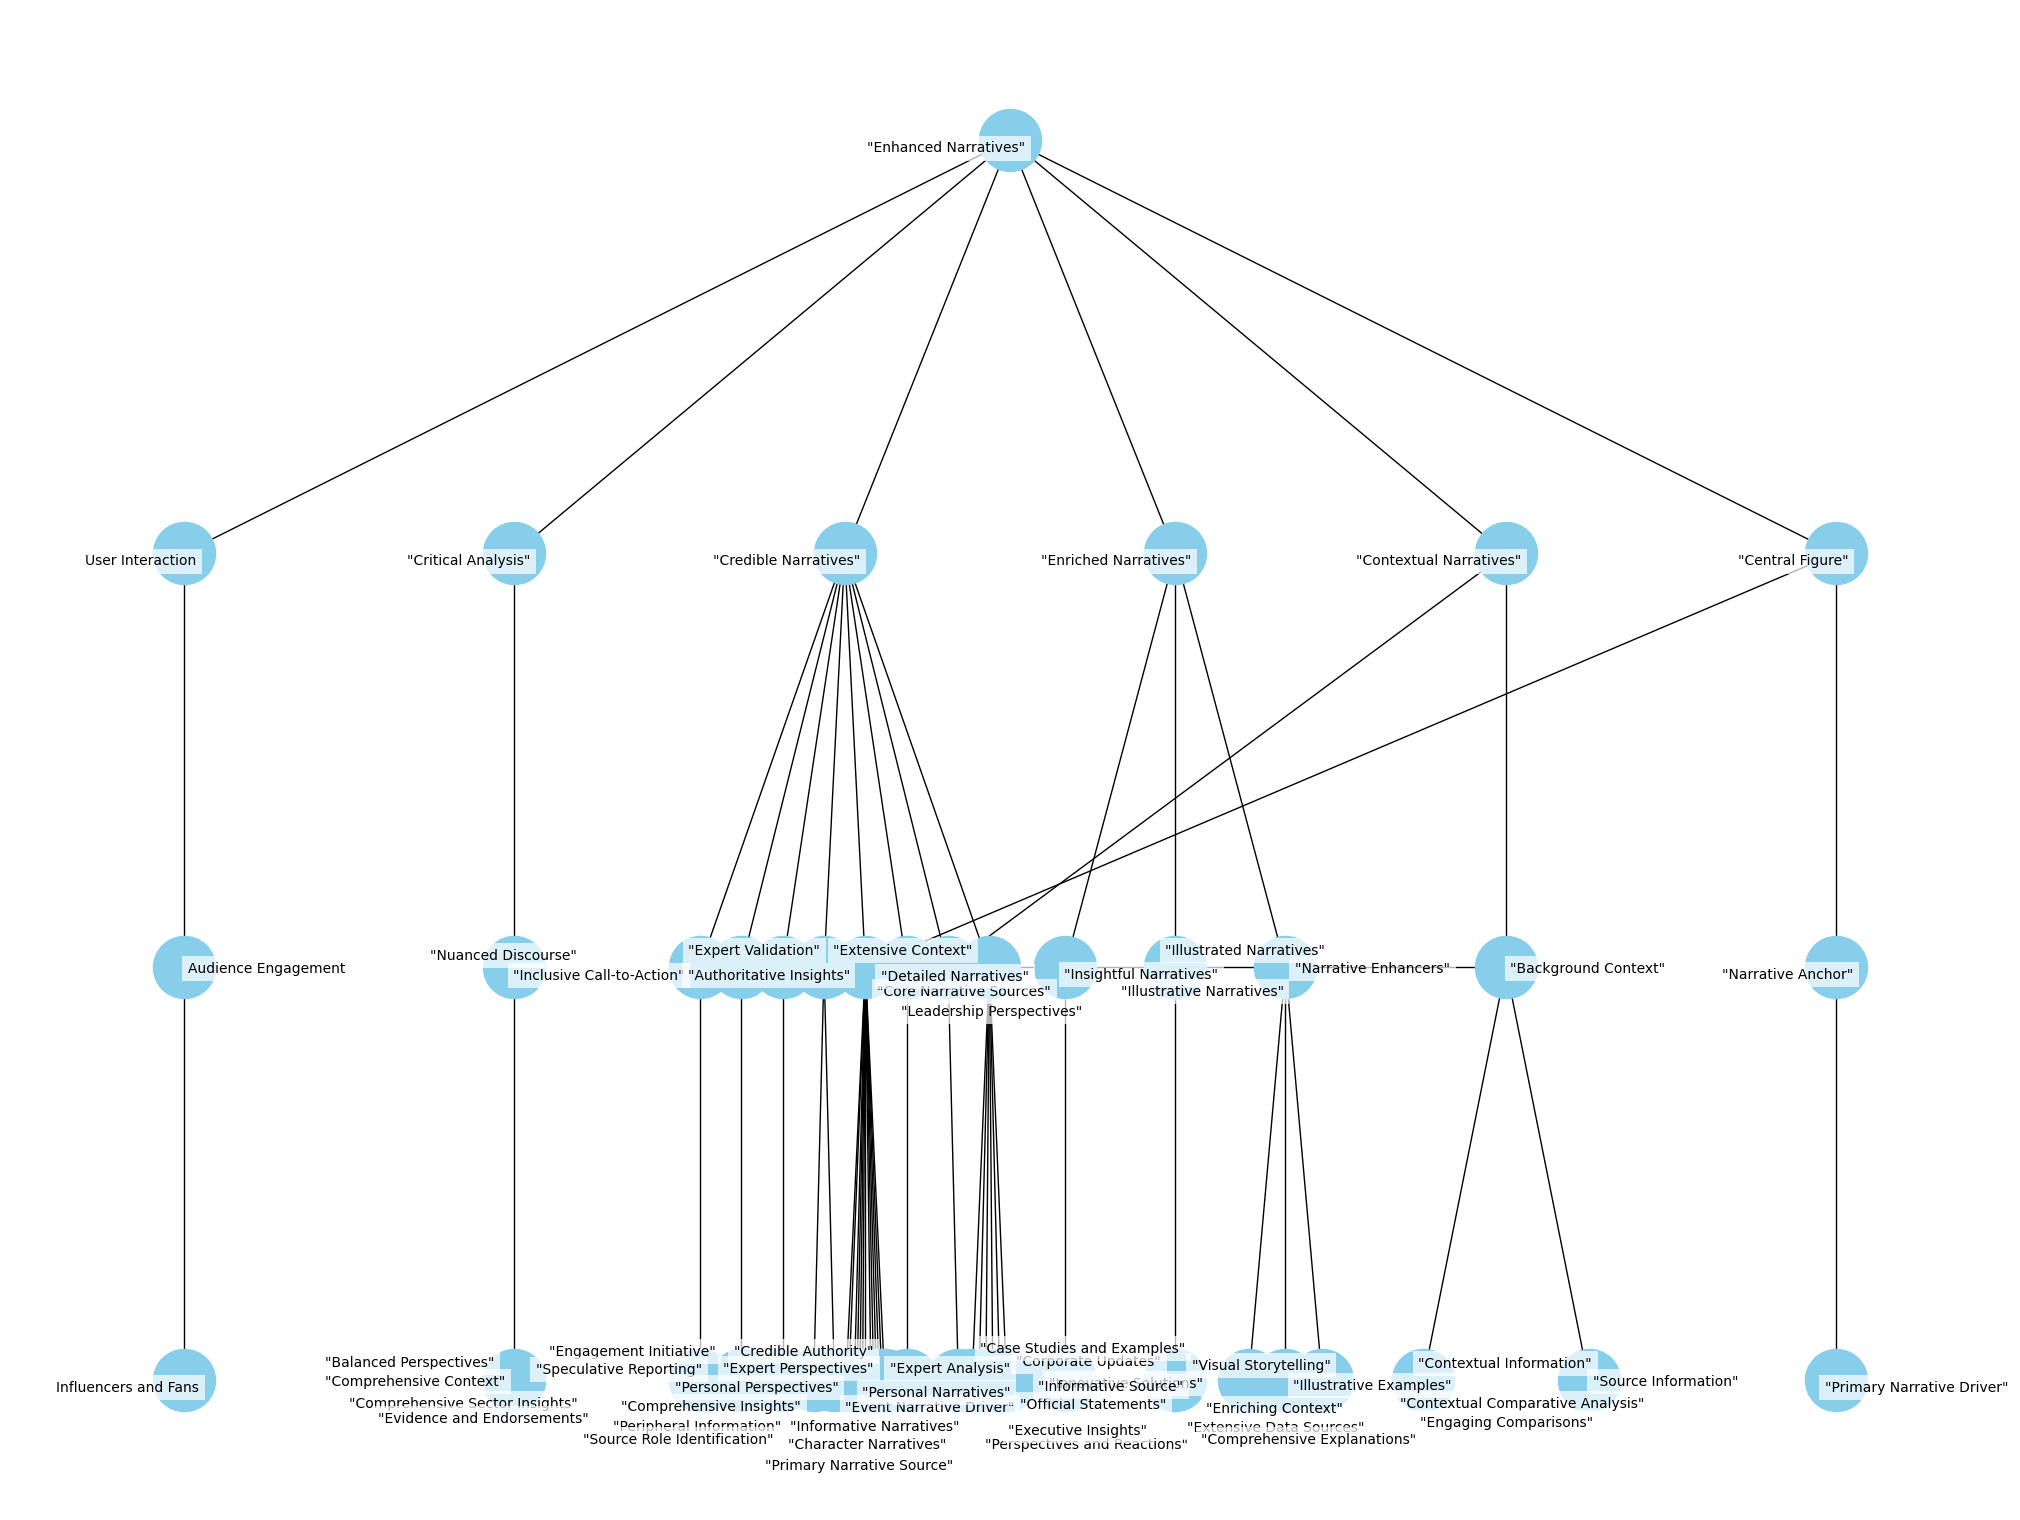

In [876]:
ut.plot_hierarchical_tree(t, depth=3, figsize=(20, 15))

In [873]:
l = build_parent_lists()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [877]:
list(reversed(l[10]))

['"Enhanced Narratives": These sources deeply enrich the storytelling by providing detailed context, expert validation, personal insights, diverse viewpoints, and engaging tools like visuals, enhancing understanding, transparency, and engagement in the article.',
 '"Credible Narratives": These sources offer comprehensive, authoritative, and diverse insights, providing detailed context, expert validation, and substantial information that enhance understanding and support the main narrative of the article.',
 '"Core Narrative Sources": These sources provide key insights, credibility, context, and diverse perspectives crucial for developing, substantiating, and advancing the main narrative of the article.',
 '"Comprehensive Insights": This collection encompasses diverse sources providing detailed perspectives, motivations, strategies, and impacts across various contexts, offering in-depth understanding, analysis, and a multifaceted view of contemporary issues.',
 '"Exclusive Insider Insig

In [568]:
l[1]

['"Disclaimer": This source is used to provide legal disclaimers, trademark information, and notices on ownership and usage terms of trademarks and content associated with the article.',
 '"Legal and Disclosure": This collection of sources is used to provide legal disclaimers, copyright information, data protection notices, and transparency statements for ensuring compliance and clarifying accountability regarding website policies, user data, content usage, and third-party affiliations.',
 '"Transparency and Compliance": This collection of sources is used to provide critical legal disclaimers, copyright information, data protection notices, transparency statements, funding details, affiliations, conflicts of interest, and practices and policies, ensuring compliance and clarifying accountability regarding website content and user data.',
 '"Source Credibility": This label provides comprehensive information regarding the financial, professional, and biographical context, including affili

# Associate clusters with Sources

In [900]:
bins=list(clustering_rounds.keys())
bins

[150, 40, 15, 6, 1, 0]

In [888]:
for k in clustering_rounds:
    clustering_rounds[k]
    break

In [889]:
clustering_rounds[k]

,child_cluster,cluster_description,parent_cluster,parent_round,current_round
0,0,"""Counterpoint"": This collection of sources is ...",1,40,150
1,1,"""Disclaimer"": This source is used to provide l...",35,40,150
2,2,"""Main Actor"": This source is the principal foc...",65,40,150
3,3,"""Authority"": This source is used to provide ex...",5,40,150
4,4,"""Main Actor"": This source is the central figur...",65,40,150
...,...,...,...,...,...
1019,1019,"""Counterpoint"": This group of sources is used ...",40,40,150
1020,1020,"""Support and Advocacy"": This group of sources ...",107,40,150
1021,1021,"""Contrasting Example"": These sources are used ...",121,40,150
1022,1022,"""Predictive Analysis Source"": This consolidate...",44,40,150


In [904]:
bins

[150, 40, 15, 6, 1, 0]

In [928]:
source_df_with_clusters = (
    source_df
         .loc[lambda df: df['Is_Error'] == False]
         .drop(columns=['Is_Error', 'Unnamed: 0'])
         .merge(clustering_rounds[bins[0]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='clusters')
         .drop(columns=['child_cluster', 'clusters']).rename(columns={'cluster_description': 'cluster_descript_leaf_1'})
         .merge(clustering_rounds[bins[1]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_2', 'parent_cluster_y': 'parent_cluster'})
         .merge(clustering_rounds[bins[2]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_3', 'parent_cluster_y': 'parent_cluster'})
         .merge(clustering_rounds[bins[3]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_4', 'parent_cluster_y': 'parent_cluster'}) 
         .merge(clustering_rounds[bins[4]][['child_cluster', 'cluster_description', 'parent_cluster']], right_on='child_cluster', left_on='parent_cluster')
         .drop(columns=['child_cluster', 'parent_cluster_x']).rename(columns={'cluster_description': 'cluster_descript_leaf_5', 'parent_cluster_y': 'parent_cluster'}) 
         .drop(columns=['parent_cluster'])
)

In [929]:
source_df_with_clusters['cluster_descript_leaf_1'].str.split(':').str.get(0).str.split('\n\n').str.get(0).value_counts()

cluster_descript_leaf_1
"Context"                                       20917
"Main Actor"                                    17606
"Counterpoint"                                  17239
"Expert Opinion"                                13660
"Context Provider"                               9324
                                                ...  
"National Day Promotion Participant"               61
"Weather Forecasts and Reports"                    59
"Interest Point Category"                          59
"Veterans Day Offers and Holiday Promotions"       54
"Problem Illustration"                             54
Name: count, Length: 607, dtype: int64

In [930]:
source_df_with_clusters['cluster_descript_leaf_2'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_2
"Context Overview"                   16655
"Main Actor"                         14915
"Expert Analysis and Insight"        11301
"Contextual Background Providers"    11107
"Counterpoint"                       10942
                                     ...  
"Contact Details"                      166
"\nEmpty Content\n"                     94
Public Figures and Admirers             82
"Core Evidence"                         61
"Story Focus"                           19
Name: count, Length: 140, dtype: int64

In [931]:
source_df_with_clusters['cluster_descript_leaf_3'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_3
"Comprehensive Context"              67936
"Balanced Perspectives"              31256
"Primary Narrative Source"           28781
"Expert Analysis"                    27784
"Comprehensive Insights"             22658
"Informative Source"                 21145
"Primary Narrative Driver"           20324
"Extensive Data Sources"             19166
"Expert Perspectives"                18821
"Case Studies and Examples"          15846
"Perspectives and Reactions"         14156
"Source Role Identification"         11133
"Source Information"                 10278
"Evidence and Endorsements"           9614
"Credible Authority"                  9071
"Corporate Updates"                   8291
"Informative Narratives"              8204
"Illustrative Examples"               7823
"Official Statements"                 7382
"Executive Insights"                  6224
"Contextual Narratives"               6217
"Personal Perspectives"               5832
"Contextual Comparative Analys

In [932]:
source_df_with_clusters['cluster_descript_leaf_4'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_4
"Core Narrative Sources"      148915
"Extensive Context"            70762
"Insightful Narratives"        55396
"Nuanced Discourse"            31256
"Narrative Anchor"             20324
"Authoritative Insights"       18821
"Illustrative Narratives"      15846
"Narrative Enhancers"          14458
"Background Context"           13348
"Detailed Narratives"           9901
"Expert Validation"             9071
"Leadership Perspectives"       6224
"Inclusive Call-to-Action"      1133
"Illustrated Narratives"         766
Audience Engagement               82
Name: count, dtype: int64

In [933]:
source_df_with_clusters['cluster_descript_leaf_5'].str.split(':').str.get(0).str.split('\n\n').str.get(0).str.strip().value_counts()

cluster_descript_leaf_5
"Credible Narratives"      320223
"Critical Analysis"         31256
"Enriched Narratives"       31070
"Central Figure"            20324
"Contextual Narratives"     13348
User Interaction               82
Name: count, dtype: int64

In [935]:
source_df_with_clusters.to_csv('cache/2024-09-19__source-df-with-all-clusters.csv')

# Agglomerative Hierarchical Clustering

In [325]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')#, metric='cosine')
model.fit(cluster_centers)

AgglomerativeClustering(distance_threshold=0, linkage='single', n_clusters=None)

In [326]:
# children_array-like of shape (n_samples-1, 2)
#     The children of each non-leaf node. 
#     Values less than n_samples correspond to leaves of the tree which are the original samples. 
#     A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]. 
#     Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i.

# distances_array-like of shape (n_nodes-1,)
#     Distances between nodes in the corresponding place in children_. 
#     Only computed if distance_threshold is used or compute_distances is set to True.

In [327]:
# Build counts and linkage_matrix
counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

# Initialize dictionaries
node_samples = {}
node_summaries = {}

In [328]:
# Get node IDs and their corresponding heights (distances)
node_ids = range(n_samples, linkage_matrix.shape[0] + n_samples)
heights = linkage_matrix[:, 2]  # distances
node_heights = list(zip(node_ids, heights))

# Sort nodes by their heights (from lowest to highest)
node_heights_sorted = sorted(node_heights, key=lambda x: x[1])

In [329]:
INNER_NODE_PROMPT = """
You are a helpful assistant. I will give you a two labels I wrote.

Here are the labels:

{labels}

Please condense them into a single, specific label, focusing on their commonalities. 
Be as concise as possible! Avoid words like "Extensive", "Comprehensive", and "Holistic". 
Focus on the narrative role of the source, less on specific industries or topics they might cover.
Please return just one 2-3 word label and one description. Make it in the same format as the input labels.
"""

In [330]:
# Loop over all non-leaf nodes from the lowest upwards
for node_id, _ in tqdm(node_heights_sorted):
    children = get_immediate_children(node_id)
    labels = []
    for child_id in children:
        if child_id < n_samples:
            label = child_node_summaries[child_id]
        else:
            label = node_summaries[child_id]
        labels.append(label)
    labels_str = '\n'.join(labels)
    prompt = INNER_NODE_PROMPT.format(labels=labels_str)
    output = call_openai_completions(prompt=prompt)
    node_summaries[node_id] = output

  0%|          | 0/1023 [00:00<?, ?it/s]

In [331]:
def print_tree(node_id, level=0, max_nodes=None, nodes_printed=[0]):
    if max_nodes is not None and nodes_printed[0] >= max_nodes:
        return
    indent = '    ' * level
    summary = node_summaries.get(node_id, "No summary available")
    print(f"{indent}- Node {node_id}: {summary}")
    nodes_printed[0] += 1
    if node_id < n_samples:
        # Leaf node; no further traversal
        return
    # Get immediate children
    children = get_immediate_children(node_id)
    for child_id in children:
        if max_nodes is not None and nodes_printed[0] >= max_nodes:
            return
        print_tree(child_id, level + 1, max_nodes, nodes_printed)

# Number of nodes to print
k = 10  # You can set k to any integer value you prefer
# Start from the root node (the last node formed in the clustering)
root_node_id = 2 * n_samples - 2  # This is the ID of the root node

# Call the function to print the tree
print_tree(root_node_id, max_nodes=k)

- Node 2046: Label: "Critical Analysis"

Description: Provides context and depth to enhance understanding.
    - Node 2045: Label: "Comparative Insights"

Description: Offers critical analysis and context to enhance the article's depth and understanding.
        - Node 2044: Label: "Informed Perspectives"

Description: Provides comparative insights and critical analysis to deepen the article's context and understanding.
            - Node 2043: Label: "Contextual Comparisons"

Description: Highlights diverse viewpoints and underlying factors to enrich understanding and context within the article.
                - Node 1576: Label: "Balanced Perspectives"

Description: Sources providing varied views to enhance understanding through balanced comparisons or contrasting points.
                    - Node 1573: Label: "Diverse Views"

Description: Sources providing varied perspectives to enhance understanding through balanced comparisons or contrasting points.
                        - Nod

In [335]:
# Set the desired depth level to collect nodes
k = 12  # Change this to your desired depth level

# Identify the root node ID and collect all nodes at depth k
root_node_id = 2 * n_samples - 2  # Root node ID for hierarchical clustering
nodes_at_depth_k = collect_nodes_at_depth_k(root_node_id, target_level=k)

# Now, print the summaries of all nodes at depth k
print('-------------------------------------------')
print(f'Nodes and depth: {k}')
print('-------------------------------------------')
print()
for node_id in nodes_at_depth_k:
    summary = node_summaries.get(node_id, "No summary available")
    # print(f"Node {node_id}: {summary[:200]}...")
    print(f"Node {node_id}: {summary}")
    print()

-------------------------------------------
Nodes and depth: 12
-------------------------------------------

Node 1464: Label: "Comparative Analysis"

Description: Sources offering multiple perspectives to highlight controversies and provide balanced understanding through comparisons.

Node 365: No summary available

Node 76: No summary available

Node 89: No summary available

Node 2034: **Label: Guidance Sources**

**Description: Narratives and data highlighting inspirations, ethical considerations, job markets, career opportunities, and expertise from recognized authorities.**

Node 1628: "Key Narrative Source": This source provides pivotal details and updates that shape the storyline, representing essential entities and their actions or promotional offerings on social issues and special events.

Node 1320: "Context Source": These sources provide background information and broader connections that enhance understanding and situate content within a broader framework.

Node 1082: "COV

In [306]:
# Build the parent mapping
parent_dict = build_parent_dict()

In [307]:
# Choose a leaf node ID to trace (must be less than n_samples)
leaf_node_id = 100  # Replace this with the actual leaf node ID you want to trace

# Trace the path from the leaf node to the root
path = trace_leaf_to_root(leaf_node_id, parent_dict)

# Optionally, print the summaries along the path
print('-------------------------------------------')
print(f"Tracing from leaf node {leaf_node_id} to root:")
print('-------------------------------------------')
print()

for node_id in path:
    if node_id < n_samples:
        # Leaf node; get the original text from the DataFrame
        summary = source_df.iloc[node_id]['Narrative Function']
    else:
        # Non-leaf node; get the summary from node_summaries
        summary = node_summaries.get(node_id, "No summary available")
    print(f"Node {node_id}: {summary}")
    print('       |')
    print('       v')
    print()

-------------------------------------------
Tracing from leaf node 100 to root:
-------------------------------------------

Node 100: "Primary Source": This source is used to provide primary information about the company's compensation packages, financial data, and business decisions.
       |
       v

Node 1833: "Initiatives and Innovations": This collective group of labels thoroughly documents an array of proposals, strategic goals, innovative advancements, and development efforts spanning various sectors such as technology, healthcare, labor, economy, environment, and governance. It encompasses the introduction of new initiatives and strategic objectives, as well as highlighting forward-thinking and creative solutions, significant progress, new corporate appointments, product innovations, policy changes, and future plans across multiple industries.
       |
       v

Node 1927: "Innovations and Transitions Summary Label: This source covers topics related to the introduction of new